In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec
import numexpr as ne
from numpy import cos, sin
from pysindy.utils import enzyme, pendulum_on_cart

In [2]:
# Julia language is required for SINDy-PI to be able to solve
# the differential algebraic equations (DAEs)
# Note that on my computer, at a terminal, I need to do:
# > julia  (enters the julia console)
# > import Pkg
# > Pkg.add("PyCall")
# > Pkg.add("DiffEqBase")
# > Pkg.add("DifferentialEquations")
# > exit()
# jupyter notebook (startup this notebook)

# Last thing to do (maybe specific to my installation)
from julia.api import Julia
jl = Julia(compiled_modules=False)
from diffeqpy import de

In [3]:
# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8,8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 'r')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 'k')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.savefig(filename + '_3d.pdf')


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r')
        plt.plot(t, xdot_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r')
        plt.plot(t, x_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')
    

# Fix feature names
def fix_feature_names(feature_names, r):
    for i in range(len(feature_names)):
        if feature_names[i] == '':
            feature_names[i] = '1'
        for j in range(r):
            feature_names[i] = feature_names[i].replace("sin(x" + str(j) + ")", "sin(u[" + str(j) + "])*")  
            feature_names[i] = feature_names[i].replace("cos(x" + str(j) + ")", "cos(u[" + str(j) + "])*")
        for j in range(r):
            feature_names[i] = feature_names[i].replace("xdot" + str(j), "du[" + str(j) + "]*")  
            feature_names[i] = feature_names[i].replace("x" + str(j), "u[" + str(j) + "]*") 
        if feature_names[i][-1] == '*':
            feature_names[i] = feature_names[i][:-1]
        print(i, feature_names[i])
    return feature_names


# Function to build a symbolic DAE
# Extract the coefficients and build up a string to evaluate
def build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_indices):
    full_string = ''
    for k in range(r):
        eval_string = ''
        for i in range(len(feature_names)):
            eval_string += 'coefs[' + str(i) + ', ' + str(k) + '] * eval(feature_names[' + str(i) + '])'
            if i != len(feature_names) - 1:
                eval_string += ' + '
            else:
                eval_string += ' - eval(feature_names[' + str(coef_indices[k]) + '])' # du[' + str(k) + ']'
        # Okay, now have the eval string for one of the ODEs and need to string together
        if k == 0 and r == 1:
            full_string = eval_string
        elif k == 0:
            full_string += '[' + eval_string + ', '
        elif k != 0 and k != r - 1:
            full_string += eval_string + ', '
        elif k != 0 and k == r - 1:
            full_string += eval_string + ']'
    return full_string


# Definition of the model error for choosing a model at the end
def model_error(xdot_test, Theta, full_coefficients):
    return np.linalg.norm(Theta - Theta @ full_coefficients, axis=0) / np.linalg.norm(Theta, axis=0) 


# Definition of the derivative prediction error for choosing a model at the end
def prediction_error(xdot_test, xdot_test_pred):
    return np.linalg.norm(xdot_test - xdot_test_pred, axis=0) / np.linalg.norm(xdot_test, axis=0)

In [4]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
x0_train = np.random.rand(r) - 0.5
x_train = integrate.odeint(enzyme, x0_train, t)
x0_test = np.random.rand(r)
x_test = integrate.odeint(enzyme, x0_test, t)

# define hyperparameters
threshold = 1e-2

fd = FiniteDifference(drop_endpoints=False)
xdot_train = np.nan_to_num(fd._differentiate(x_train, t)) # * dt)
xdot_test = np.nan_to_num(fd._differentiate(x_test, t)) # * dt)

# Initialize custom SINDy library so that we can have xdot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [lambda x:1, lambda x:x, lambda x, y:x * y, lambda x:x ** 2, 
                       lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3,
                       lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                       lambda x, y:x * y ** 3, lambda x:x ** 4]
xdot_library_functions = [lambda x:1, lambda x:x]
        
library_function_names = [lambda x:'', lambda x:x, lambda x, y: x + y, lambda x:x + x, 
                          lambda x, y, z:x + y + z, lambda x, y: x + y + y, lambda x: x + x + x,
                          lambda x, y, z, w: x + y + z + w, lambda x, y, z:x + y + z + z,
                          lambda x, y:x + y + y + y, lambda x:x + x + x + x,
                          lambda x:'', lambda x:x] 
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1", max_iter=20000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)

(499, 1)
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 519, constraints m = 520
          nnz(P) + nnz(A) = 6029
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 20000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.1851e-02   1.00e+00   3.37e+04   1.00e-01   1.30e-03s
 100   1.1615e-01   1.97e-05   5.00e-09   1.13e-03   3.80e-03s

status:               solved
solut

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 519, constraints m = 520
          nnz(P) + nnz(A) = 6029
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 20000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.1851e-02   1.19e-01   4.32e-01   1.00e-01   6.18e-04s
  50   1.4722e-07   8.63e-06   5.87e-12   6.76e+00   2.12e-03s

status:               solved
solution polis

SINDy(differentiation_method=FiniteDifference(drop_endpoints=True),
      feature_library=<pysindy.feature_library.SINDyPI_library.SINDyPILibrary object at 0x7f85762291d0>,
      feature_names=['x0'],
      optimizer=SINDyPIoptimizer(max_iter=20000, threshold=0.01))

[1]
0 1
1 du[0]
2 u[0]
3 u[0]*du[0]
4 u[0]*u[0]
5 u[0]*u[0]*du[0]
6 u[0]*u[0]*u[0]
7 u[0]*u[0]*u[0]*du[0]
8 u[0]*u[0]*u[0]*u[0]
9 u[0]*u[0]*u[0]*u[0]*du[0]
[[ 4.69441532e-01]
 [ 5.77903569e-08]
 [-2.35867213e+00]
 [-2.49926839e-01]
 [-2.63471178e-06]
 [-4.24601968e-08]
 [-4.88659225e-07]
 [-2.17101254e-08]
 [-8.53373349e-08]
 [-4.64219692e-09]] du[0]


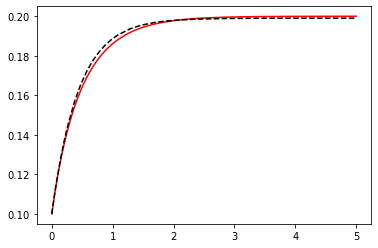

In [6]:
coef_indices = np.arange(1, r + 1)
print(coef_indices)
coefs = (sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, 1, coefs, coef_indices)
print(coefs, feature_names[coef_indices[0]])

# Define a SINDy differential algebraic equation (DAE)
def SINDy_model(du, u, p, t):
    resid = eval(eval_string)
    return resid


u0 = [0.1]
du0 = [-0.04]
tspan = (0.0,5.0)
differential_vars = [True]
prob = de.DAEProblem(SINDy_model, du0, u0, tspan, differential_vars=differential_vars)
plt.plot(t, integrate.odeint(enzyme, u0[0], t), 'r')
sol = de.solve(prob)
plt.plot(sol.t, sol.u, 'k--')

In [7]:
model.print()

()' = 0.469 xdot0 + 0.199 x0 + 0.001 x0xdot0 + 0.008 x0x0x0 + 0.001 x0x0x0x0
(xdot0)' = 1.781  + -0.425 x0 + 0.082 x0xdot0 + -0.037 x0x0 + 0.006 x0x0xdot0 + -0.026 x0x0x0 + -0.004 x0x0x0x0
(x0)' = 5.007  + -2.359 xdot0 + 0.196 x0x0
(x0xdot0)' = 4.217  + -0.250 xdot0
(x0x0)' = 0.000
(x0x0xdot0)' = 0.000
(x0x0x0)' = 0.000
(x0x0x0xdot0)' = 0.000
(x0x0x0x0)' = 0.000
(x0x0x0x0xdot0)' = 0.000


In [14]:
# define parameters
r = 4
dt = 0.05
T = 50
t = np.arange(0, T + dt, dt)

x0_train = [0.3, 0, 1, 10]
x_train = integrate.odeint(pendulum_on_cart, x0_train, t)
x0_test = [np.pi, 0, 0, 20]
x_test = integrate.odeint(pendulum_on_cart, x0_test, t)

# define hyperparameters
threshold = 1e-1

xdot_train = np.nan_to_num(fd._differentiate(x_train, t))
xdot_test = np.nan_to_num(fd._differentiate(x_test, t))

x_library_functions = [lambda x:1, lambda x:x, lambda x:cos(x), lambda x:sin(x),
                       lambda x: sin(x) * sin(x), lambda x: sin(x) * cos(x)]
xdot_library_functions = [lambda x:1, lambda x:x, lambda x:x ** 2]
        
library_function_names = [lambda x:'', lambda x:x, lambda x:'cos(' + x + ')', lambda x: 'sin(' + x + ')',
                          lambda x: 'sin(' + x + ')' + 'sin(' + x + ')', 
                          lambda x: 'sin(' + x + ')' + 'cos(' + x + ')',
                          lambda x:'', lambda x:x, lambda x: x + x] 

sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  t=t[1:-1],
                                  function_names=library_function_names,
                                  )

sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-3, thresholder="l1", max_iter=2000)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
print(model.get_feature_names())
print(np.shape(model.get_feature_names()))
print(np.shape(sindy_opt.Theta), np.shape(sindy_opt.coef_))

(999, 4)
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   2.55e+04   1.00e-01   4.21e-02s
 100   5.4484e-04   1.65e-05   4.26e-04   2.35e+02   1.53e-01s

status:               solved
so

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   2.20e+03   1.00e-01   4.39e-02s
 150   9.4354e-03   1.13e-03   1.91e-04   4.85e+00   1.98e-01s

status:               solved
solution po

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   1.46e+01   2.19e+03   1.00e-01   4.42e-02s
  50   1.0052e-02   8.64e-03   3.39e-04   8.10e-01   1.17e-01s

status:               solved
solution po


status:               solved
solution polish:      unsuccessful
number of iterations: 150
optimal objective:    0.0208
run time:             2.69e-01s
optimal rho estimate: 1.35e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res   

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   1.50e+04   1.00e-01   4.25e-02s
  75   1.0333e-02   2.95e-03   5.23e-04   1.86e+00   1.33e-01s

status:               solved
solution po

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   1.26e+02   2.39e+06   1.00e-01   4.37e-02s
  75   1.3972e-01   3.15e-02   1.00e-03   1.00e-01   1.05e-01s

status:               solved
solution po

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   1.29e+03   1.00e-01   4.29e-02s
 125   1.2066e-03   1.47e-05   7.13e-04   4.54e+02   2.37e-01s

status:               solved
solution po

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   1.10e+02   1.00e-01   4.33e-02s
 200   7.2905e-02   3.24e-03   1.41e-04   8.18e-01   2.99e-01s
 300   7.4437e-02   2.12e-03   2.19e-05  

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   1.02e+02   1.00e-01   4.32e-02s
 200   2.3942e-02   2.39e-03   9.78e-05   3.99e+00   2.34e-01s
 325   2.4823e-02   1.08e-03   1.60e-05  


status:               solved
solution polish:      unsuccessful
number of iterations: 200
optimal objective:    0.0733
run time:             2.77e-01s
optimal rho estimate: 6.39e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res   

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   5.79e+02   1.00e-01   4.26e-02s
 100   5.2433e-03   1.05e-03   6.21e-05   9.46e+00   1.53e-01s

status:               solved
solution po

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   1.92e+04   1.00e-01   4.30e-02s
 100   1.1161e-03   1.88e-05   8.17e-04   1.05e+02   2.16e-01s

status:               solved
solution po

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   6.54e+00   1.00e-01   4.28e-02s
 200   1.8179e+01   1.09e-03   2.86e-05   2.24e+01   2.35e-01s

status:               solved
solution po


status:               solved
solution polish:      unsuccessful
number of iterations: 100
optimal objective:    0.0021
run time:             2.61e-01s
optimal rho estimate: 1.27e+02

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res   

 225   6.6697e-02   1.45e-03   2.55e-05   6.90e+00   2.54e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 225
optimal objective:    0.0667
run time:             2.98e-01s
optimal rho estimate: 4.28e+00

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish:

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   1.64e+03   1.00e-01   4.26e-02s
 150   8.0130e-03   8.53e-04   3.85e-05   5.62e+00   1.93e-01s

status:               solved
solution po


status:               solved
solution polish:      unsuccessful
number of iterations: 125
optimal objective:    0.0017
run time:             2.80e-01s
optimal rho estimate: 7.41e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res   

 700   5.1858e-01   1.15e-02   4.74e-05   1.83e-02   6.35e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 700
optimal objective:    0.5186
run time:             6.78e-01s
optimal rho estimate: 1.61e-02

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish:

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   1.10e+01   1.86e+05   1.00e-01   4.30e-02s
 100   9.7573e-03   5.32e-05   3.72e-04   2.05e+01   1.85e-01s

status:               solved
solution po

 400   1.8917e-01   1.30e-02   1.03e-05   2.82e-01   4.25e-01s
 600   1.9298e-01   7.80e-03   8.62e-06   1.86e+00   6.17e-01s
 800   1.9509e-01   4.23e-03   9.04e-06   1.86e+00   7.79e-01s

status:               solved
solution polish:      unsuccessful
number of iterations: 800
optimal objective:    0.1951
run time:             8.22e-01s
optimal rho estimate: 9.37e-01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
 

/usr/local/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   4.70e+02   1.00e-01   4.37e-02s
 200   7.1733e-02   1.15e-02   3.76e-04   3.26e-01   2.97e-01s
 400   8.1567e-02   7.80e-03   2.77e-05  


status:               solved
solution polish:      unsuccessful
number of iterations: 125
optimal objective:    0.0042
run time:             2.49e-01s
optimal rho estimate: 2.63e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res   

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   7.46e+01   1.00e-01   4.32e-02s
 125   1.4821e-02   1.00e-03   3.41e-04   2.11e+01   2.06e-01s

status:               solved
solution po

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5120e+02   8.00e+00   1.53e+00   1.00e-01   4.31e-02s
  75   1.0771e+01   8.49e-04   1.07e-03   1.25e+02   1.66e-01s

status:               solved
solution po


status:               solved
solution polish:      unsuccessful
number of iterations: 125
optimal objective:    0.0146
run time:             2.48e-01s
optimal rho estimate: 2.94e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res   

 200   1.0386e+00   3.09e+00   9.75e-06   7.31e-05   3.60e-01s
 400   1.8491e+01   1.31e+00   3.31e-03   1.67e-02   6.15e-01s
 600   1.1184e+00   3.09e+00   2.14e-06   5.80e-04   8.42e-01s
 800   6.8478e+00   1.63e+00   3.95e-03   6.13e-03   1.07e+00s
1000   1.0658e+01   6.63e-01   3.46e-03   6.13e-03   1.23e+00s
1200   1.7784e+01   1.40e+00   1.30e-03   1.19e-03   1.42e+00s
1400   1.7708e+01   1.33e+00   5.89e-04   1.19e-03   1.58e+00s
1600   1.6616e+01   9.75e-01   1.37e-04   1.19e-03   1.74e+00s
1800   1.5272e+01   5.62e-01   1.08e-04   1.19e-03   1.90e+00s
2000   1.4084e+01   2.59e-01   1.93e-04   1.19e-03   2.06e+00s

status:               solved inaccurate
number of iterations: 2000
optimal objective:    14.0837
run time:             2.06e+00s
optimal rho estimate: 5.60e-04

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  


status:               solved
solution polish:      unsuccessful
number of iterations: 125
optimal objective:    0.0032
run time:             2.50e-01s
optimal rho estimate: 2.30e+01

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 1377, constraints m = 1378
          nnz(P) + nnz(A) = 191566
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 2000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res   

In [18]:
nonzero_coefs = (sindy_opt.coef_)[sindy_opt.coef_ > 1e-5]
print(nonzero_coefs)
model.print(precision=2)

[3.20563448e-05 1.59687026e-05 1.02661835e-05 ... 1.30539574e-04
 1.13226384e-04 1.62261594e-04]
()' = 0.00
(xdot0)' = 0.00
(xdot1)' = 0.00
(xdot2)' = 0.22 x1xdot1xdot1
(xdot3)' = -0.01 x1xdot1xdot1
(xdot0xdot0)' = 0.00
(xdot1xdot1)' = -0.01 x1xdot2 + 0.55 x3xdot1xdot1 + 0.01 sin(x2)xdot1xdot1 + 0.01 sin(x2)cos(x2)xdot1xdot1
(xdot2xdot2)' = -0.01 x3xdot1xdot1
(xdot3xdot3)' = -0.01 x3xdot1xdot1
(x0)' = -0.03 x1xdot1xdot1
(x1)' = 0.01 x1xdot0 + 5.25 x1xdot1 + -0.15 x1xdot1xdot1
(x2)' = 0.00
(x3)' = 0.00
(x0xdot0)' = -0.05 x1xdot1xdot1
(x0xdot1)' = 0.01 x1xdot0 + 0.01 x0xdot1xdot1 + -0.14 x1xdot1xdot1 + -0.01 sin(x0)xdot1xdot1
(x0xdot2)' = 12.22 x1xdot2 + 0.05 x1xdot1xdot1
(x0xdot3)' = 12.22 x1xdot3
(x1xdot0)' = 0.04 x0xdot0 + -0.01 x1xdot1 + -0.01 x1xdot2 + 1.58 x1xdot0xdot0 + -0.02 x1xdot1xdot1 + -0.07 x1xdot2xdot2 + 0.04 x1xdot3xdot3 + 0.01 x3xdot1xdot1 + 0.07 cos(x1)xdot2 + -0.01 sin(x2)xdot1xdot1 + -0.01 sin(x0)sin(x0)xdot1xdot1 + -0.01 sin(x2)sin(x2)xdot1xdot1 + 0.01 sin(x3)sin(x3)x

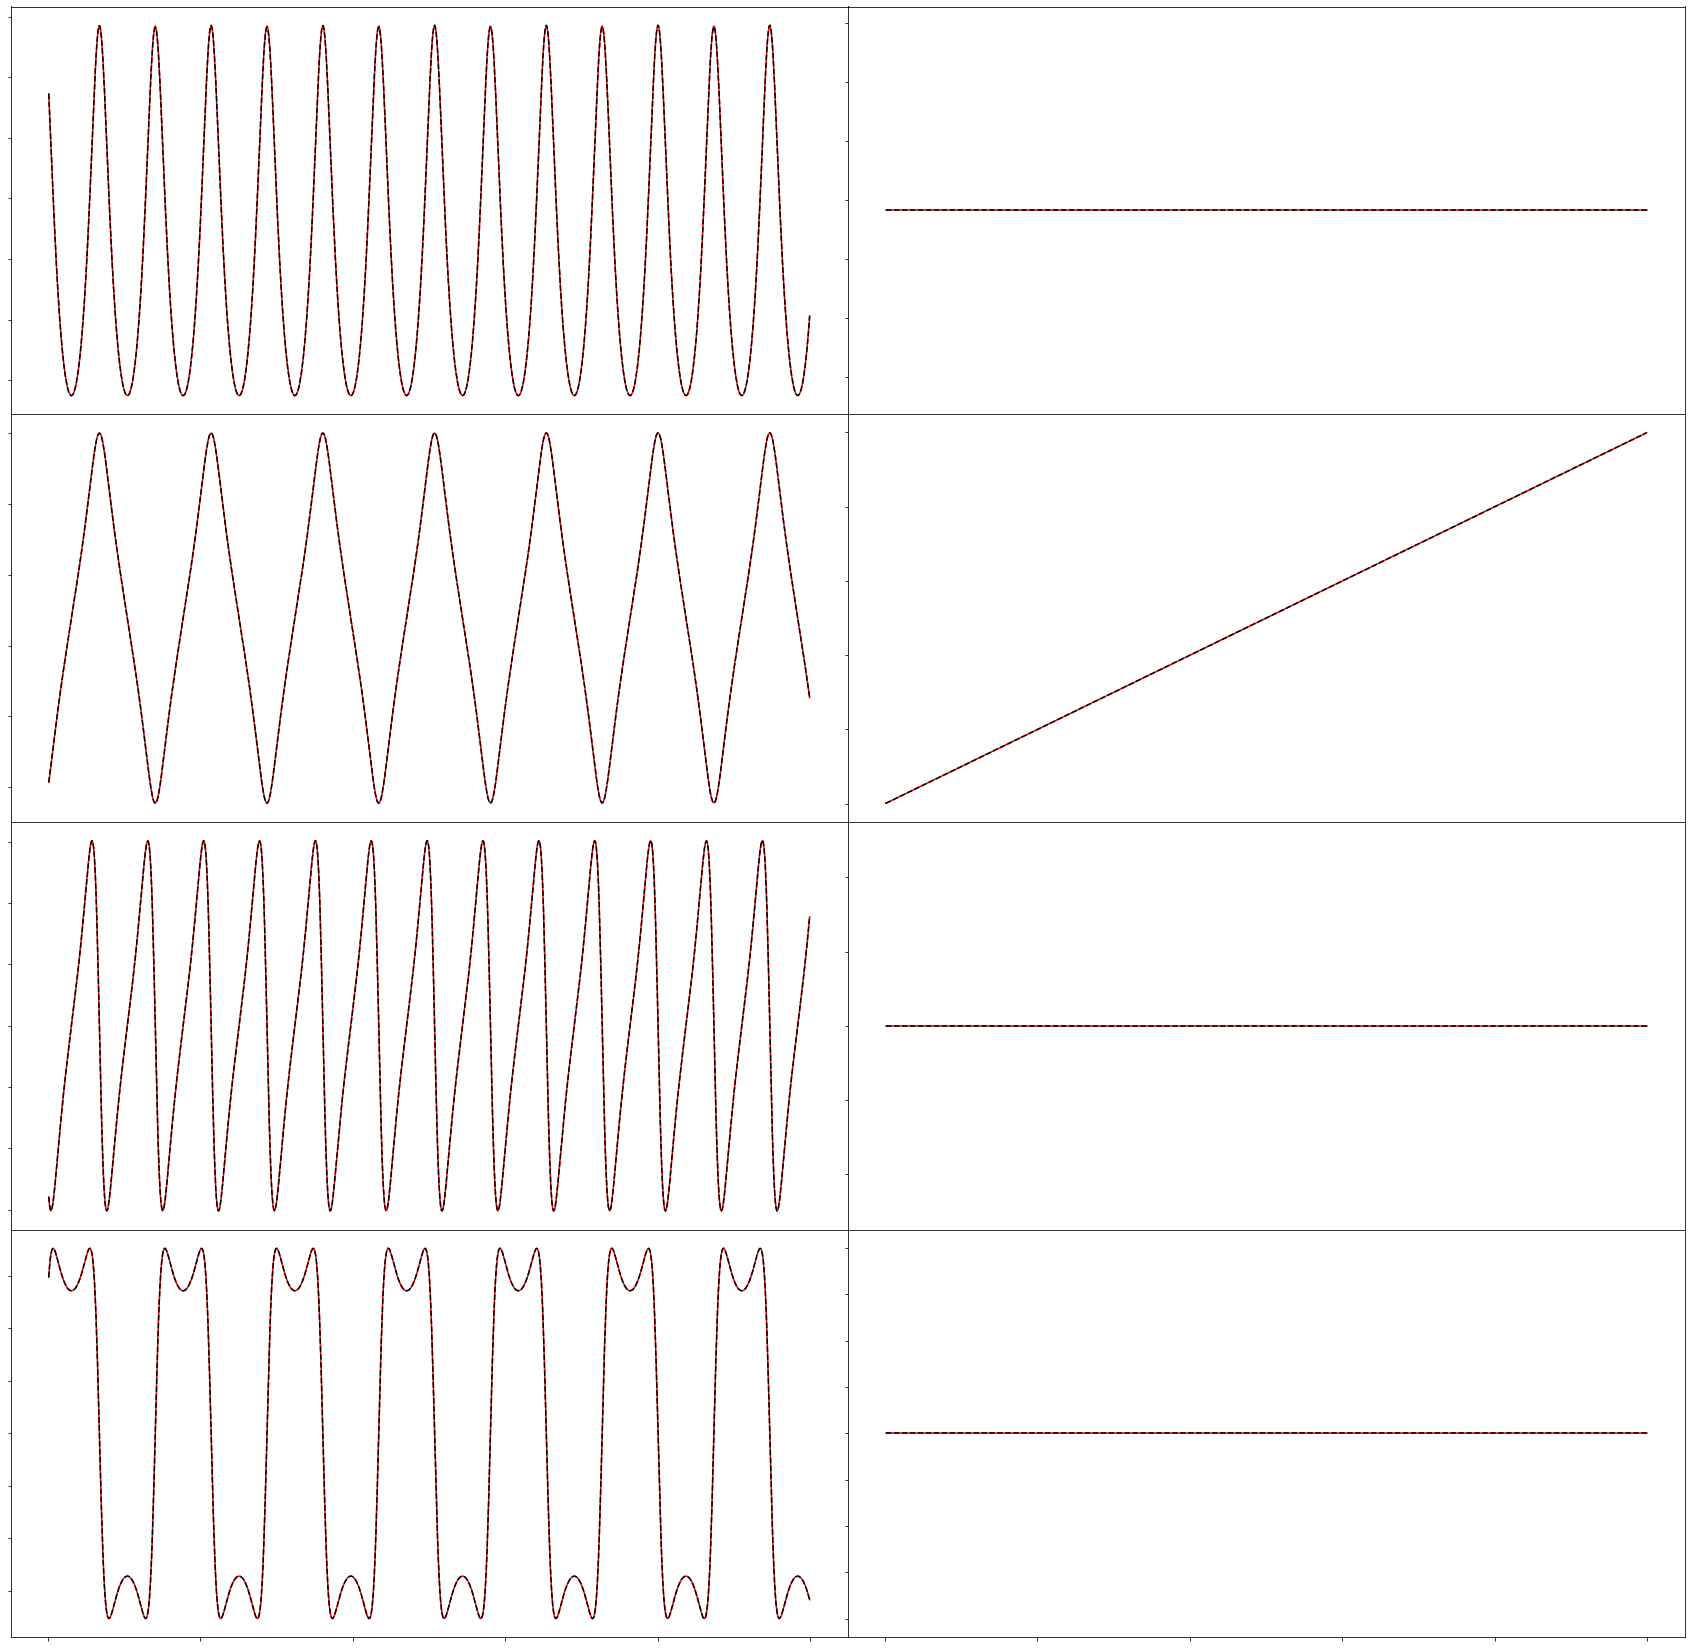

In [16]:
xdot_test = model.differentiate(x_train, t=t)[1:-1, :]
xdot_test_pred = sindy_opt.Theta @ sindy_opt.coef_
make_fits(r, t[1:-1], xdot_test, xdot_test_pred[:, 1:1+r], x_test[1:-1], x_test[1:-1], 'pendulum_on_cart')

0 1
1 du[0]
2 du[1]
3 du[2]
4 du[3]
5 du[0]*du[0]
6 du[1]*du[1]
7 du[2]*du[2]
8 du[3]*du[3]
9 u[0]
10 u[1]
11 u[2]
12 u[3]
13 u[0]*du[0]
14 u[0]*du[1]
15 u[0]*du[2]
16 u[0]*du[3]
17 u[1]*du[0]
18 u[1]*du[1]
19 u[1]*du[2]
20 u[1]*du[3]
21 u[2]*du[0]
22 u[2]*du[1]
23 u[2]*du[2]
24 u[2]*du[3]
25 u[3]*du[0]
26 u[3]*du[1]
27 u[3]*du[2]
28 u[3]*du[3]
29 u[0]*du[0]*du[0]
30 u[0]*du[1]*du[1]
31 u[0]*du[2]*du[2]
32 u[0]*du[3]*du[3]
33 u[1]*du[0]*du[0]
34 u[1]*du[1]*du[1]
35 u[1]*du[2]*du[2]
36 u[1]*du[3]*du[3]
37 u[2]*du[0]*du[0]
38 u[2]*du[1]*du[1]
39 u[2]*du[2]*du[2]
40 u[2]*du[3]*du[3]
41 u[3]*du[0]*du[0]
42 u[3]*du[1]*du[1]
43 u[3]*du[2]*du[2]
44 u[3]*du[3]*du[3]
45 cos(u[0])
46 cos(u[1])
47 cos(u[2])
48 cos(u[3])
49 cos(u[0])*du[0]
50 cos(u[0])*du[1]
51 cos(u[0])*du[2]
52 cos(u[0])*du[3]
53 cos(u[1])*du[0]
54 cos(u[1])*du[1]
55 cos(u[1])*du[2]
56 cos(u[1])*du[3]
57 cos(u[2])*du[0]
58 cos(u[2])*du[1]
59 cos(u[2])*du[2]
60 cos(u[2])*du[3]
61 cos(u[3])*du[0]
62 cos(u[3])*du[1]
63 cos(u[3])*du

[-0.591618106334406, -0.5998887871161778, -0.4825109214524571, -0.6734856624966428]
[-0.591618106334406, -0.5998887871161778, -0.4825109214524571, -0.6734856624966428]
[-1.8482251874416982, -0.599899311190534, -0.4825013606690507, -0.673502839469033]
[-0.580905930765384, -2.368976634891074, -0.48219742737765725, -0.6734403506210201]
[-0.5916321202621733, -0.5999813769032746, -1.3447743265220744, -0.6757040046976955]
[-0.5917212222666918, -0.6000315004126662, -0.4865185613074768, -1.813530481590158]
[0.0028282344841527693, -0.01288648159468088, 0.00010452651595149387, 7.43768582957329e-05]
[7.776531555268905e-05, -0.00034575682219720004, 2.2258317835062836e-06, 2.4322769025740773e-07]
[2.095603374224535e-06, -9.318435148427253e-06, 6.00531770828927e-08, 6.666523625489236e-09]
[5.64849711565334e-08, -2.511693702957067e-07, 1.618671954009351e-09, 1.7968365090088723e-10]
[5.64849711565334e-08, -2.511693702957067e-07, 1.618671954009351e-09, 1.7968365090088723e-10]
[1.2566154026311194, 2.041

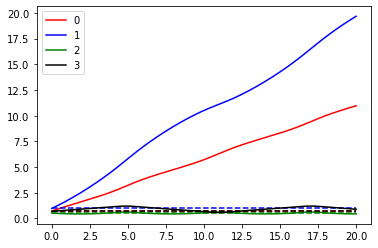

In [13]:
coef_indices = range(1, r + 1)
r = 4
coefs = (sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_indices)
print(eval_string, np.shape(coefs))

# Define a SINDy differential algebraic equation (DAE)
def SINDy_DAE(du, u, p, t):
    resid = eval(eval_string)
    print(resid)
    return resid


u0 = np.random.rand(r)  #[np.pi, 0.0, 0.0, 0.0]
du0 = np.random.rand(r)
tspan = (0.0, 20)
differential_vars = [True, True, True, True]
prob = de.DAEProblem(SINDy_DAE,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)
t_test = np.linspace(0, tspan[-1], len(t))
print(t_test)
colors = ['r', 'b', 'g', 'k']
x_test = integrate.odeint(pendulum_on_cart, u0, t_test)
for i in range(r):
    plt.plot(t_test, x_test[:, i], colors[i], label=str(i))
    plt.plot(sol.t, np.asarray(sol.u)[:, i], colors[i] + '--')
plt.legend()

du[0] -1.3569758841335908e-07
du[1] -8.550970090451334e-07
sin(u[0])*sin(u[0])*du[2]
sin(u[0])*sin(u[0])*du[3]
0 1
1 du[0]
2 du[1]
3 du[2]
4 du[3]
5 du[0]*du[0]
6 du[1]*du[1]
7 du[2]*du[2]
8 du[3]*du[3]
9 u[0]
10 u[1]
11 u[2]
12 u[3]
13 u[0]*du[0]
14 u[0]*du[1]
15 u[0]*du[2]
16 u[0]*du[3]
17 u[1]*du[0]
18 u[1]*du[1]
19 u[1]*du[2]
20 u[1]*du[3]
21 u[2]*du[0]
22 u[2]*du[1]
23 u[2]*du[2]
24 u[2]*du[3]
25 u[3]*du[0]
26 u[3]*du[1]
27 u[3]*du[2]
28 u[3]*du[3]
29 u[0]*du[0]*du[0]
30 u[0]*du[1]*du[1]
31 u[0]*du[2]*du[2]
32 u[0]*du[3]*du[3]
33 u[1]*du[0]*du[0]
34 u[1]*du[1]*du[1]
35 u[1]*du[2]*du[2]
36 u[1]*du[3]*du[3]
37 u[2]*du[0]*du[0]
38 u[2]*du[1]*du[1]
39 u[2]*du[2]*du[2]
40 u[2]*du[3]*du[3]
41 u[3]*du[0]*du[0]
42 u[3]*du[1]*du[1]
43 u[3]*du[2]*du[2]
44 u[3]*du[3]*du[3]
45 cos(u[0])
46 cos(u[1])
47 cos(u[2])
48 cos(u[3])
49 cos(u[0])*du[0]
50 cos(u[0])*du[1]
51 cos(u[0])*du[2]
52 cos(u[0])*du[3]
53 cos(u[1])*du[0]
54 cos(u[1])*du[1]
55 cos(u[1])*du[2]
56 cos(u[1])*du[3]
57 cos(u[2])*du[0]

[-0.00027725405280037643, 1.929680053515934e-09, 1.8174000370476767e-09, 6.269536102113078e-10]
[-7.900893666122189e-11, 0.00017624470567415205, -3.665257431204283e-09, -1.878238219439276e-05]
[3.7906457484274794e-10, 2.8937963796688077e-10, -6.374969445094035e-05, -1.6505527760758413e-08]
[-3.80568194179077e-11, 4.1057185039201033e-10, 1.3077902139238685e-07, 4.8023077401958606e-05]
[3.7017240746851916e-11, -1.9202383812664402e-11, 7.271586562407822e-11, -4.3364916983647164e-11]
[-0.00013862710810951686, 9.001250729846385e-10, -3.090710967584785e-09, 6.397509281486645e-09]
[-1.1091132457938733e-10, 8.81224905420277e-05, -1.2620823178886937e-09, -9.391707189212194e-06]
[3.58457487845581e-10, 1.2133285415550653e-10, -3.1876789405317906e-05, -8.407416806061544e-09]
[-5.083101378212667e-13, 1.632990496022483e-10, 6.540665125727348e-08, 2.4007715447366294e-05]
[7.057196535961849e-11, -3.6606063283805874e-11, 1.386292384851468e-10, -8.267169506140522e-11]
[-7.272247827840405e-05, 3.97785520

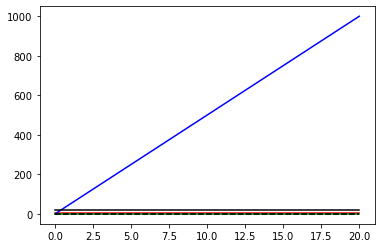

In [20]:
# These are the four coefficients we ideally want
print(feature_names[1], sindy_opt.coef_[3, 1])
print(feature_names[2], sindy_opt.coef_[4, 2])
print(feature_names[123])
print(feature_names[124])

coef_indices = [1, 2, 123, 124]
r = 4
coefs = (sindy_opt.coef_)[:, coef_indices]
feature_names = model.get_feature_names()
feature_names = fix_feature_names(feature_names, r)
eval_string = build_symbolic_DAE(sindy_opt, feature_names, r, coefs, coef_indices)
prob = de.DAEProblem(SINDy_DAE,du0,u0,tspan,differential_vars=differential_vars)
sol = de.solve(prob)
for i in range(r):
    plt.plot(t_test, x_test[:, i], colors[i], label=str(i))
    plt.plot(sol.t, np.asarray(sol.u)[:, i], colors[i] + '--')
print(sol)